In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
plt.style.use('ggplot')
plt.rcParams['image.cmap'] = 'gray'

In [9]:
# configuration
dir_to_save = '/home/givasile/stereo_vision/paper/'

paths_to_results_freiburg = {
    'one_res_small' : '/home/givasile/stereo_vision/saved_models/vol2/simple_net/experiment_1/checkpoint_10.tar',
    'one_res_big' : '/home/givasile/stereo_vision/saved_models/vol2/simple_net_more/experiment_1/checkpoint_10.tar',
    'mres_2d_small' : '/home/givasile/stereo_vision/saved_models/vol2/multires_2d_less/experiment_1/checkpoint_10.tar',
    'mres_2d_big' : '/home/givasile/stereo_vision/saved_models/vol2/multires_2d/experiment_1/checkpoint_10.tar',
    'mres_3d_small' : '/home/givasile/stereo_vision/saved_models/vol2/multires_3d_less/experiment_1/checkpoint_10.tar',
    'mres_3d_big' : '/home/givasile/stereo_vision/saved_models/vol2/multires_3d/experiment_1/checkpoint_10.tar',
    'mres_2d_3d_small' : '/home/givasile/stereo_vision/saved_models/vol2/multires_2d_3d_less/experiment_1/checkpoint_10.tar',
    'mres_2d_3d_big' : '/home/givasile/stereo_vision/saved_models/vol2/multires_2d_3d/experiment_1/checkpoint_10.tar',
    'scalable_net' : '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features/experiment_1/checkpoint_10.tar',
    'scalable_net_free_2d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_2d_weights/experiment_1/checkpoint_15.tar',
    'scalable_net_free_3d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_3d_weights/experiment_1/checkpoint_15.tar',
    'scalable_net_free_2d_3d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_2d_3d_weights/experiment_1/checkpoint_13.tar'
    }

def create_path(name):
    return '/home/givasile/stereo_vision/saved_models/vol2/' + name + '/experiment_2/checkpoint_200.tar'
paths_to_results_kitti2015 = {
    'one_res_small' : create_path('simple_net'),
    'one_res_big' : create_path('simple_net_more'),
    'mres_2d_small' : create_path('multires_2d_less'),
    'mres_2d_big' : create_path('multires_2d'),    
    'mres_3d_small' : '/home/givasile/stereo_vision/saved_models/vol2/multires_3d_less/experiment_2/checkpoint_200.tar',
    'mres_3d_big' : '/home/givasile/stereo_vision/saved_models/vol2/multires_3d/experiment_2/checkpoint_200.tar',
    'mres_2d_3d_small' : '/home/givasile/stereo_vision/saved_models/vol2/multires_2d_3d_less/experiment_2/checkpoint_200.tar',
    'mres_2d_3d_big' : '/home/givasile/stereo_vision/saved_models/vol2/multires_2d_3d/experiment_2/checkpoint_200.tar',
    'scalable_net' : '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features/experiment_2/checkpoint_200.tar',
    'scalable_net_free_2d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_2d_weights/experiment_2/checkpoint_200.tar',
    'scalable_net_free_3d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_3d_weights/experiment_2/checkpoint_200.tar',
    'scalable_net_free_2d_3d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_2d_3d_weights/experiment_2/checkpoint_200.tar'
    }

def create_path(name):
    return '/home/givasile/stereo_vision/saved_models/vol2/' + name + '/experiment_3/checkpoint_200.tar'
paths_to_results_kitti2012 = {
    'one_res_small' : create_path('simple_net'),
    'one_res_big' : create_path('simple_net_more'),
    'mres_2d_small' : create_path('multires_2d_less'),
    'mres_2d_big' : create_path('multires_2d'),
    'mres_3d_small' : create_path('multires_3d_less'),
    'mres_3d_big' : create_path('multires_3d'),
    'mres_2d_3d_small' : '/home/givasile/stereo_vision/saved_models/vol2/multires_2d_3d_less/experiment_3/checkpoint_84.tar',
    'mres_2d_3d_big' : create_path('multires_2d_3d'),
    'scalable_net' : '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features/experiment_3/checkpoint_200.tar',
    'scalable_net_free_2d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_2d_weights/experiment_3/checkpoint_200.tar',
    'scalable_net_free_3d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_3d_weights/experiment_3/checkpoint_200.tar',
    'scalable_net_free_2d_3d': '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features_free_2d_3d_weights/experiment_3/checkpoint_200.tar'
    }

In [3]:
key1 = {
    'one_res_small' : 'OneRes (S)',
    'one_res_big' : 'OneRes (B)',
    'mres_2d_small' : 'MRes2d (S)',
    'mres_2d_big' : 'MRes2d (B)',
    'mres_3d_small' : 'MRes3d (S)',
    'mres_3d_big' : 'MRes3d (B)',
    'mres_2d_3d_small' : 'MRes2d3d (S)',
    'mres_2d_3d_big' : 'MRes2d3d (B)',
    'scalable_net' : 'MSNet',
    'scalable_net_free_2d': 'MSNet Free2d',
    'scalable_net_free_3d': 'MSNet Free3d',
    'scalable_net_free_2d_3d': 'MSNet Free2d3d'
    }

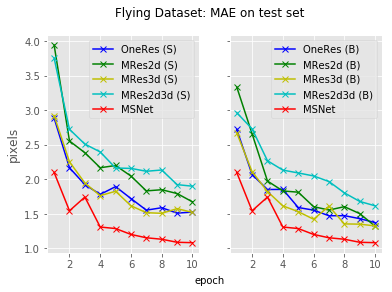

In [4]:
paths_to_results_freiburg['scalable_net'] = '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features/experiment_1/checkpoint_10.tar'

# figure 1
fig, ax = plt.subplots(1, 2, sharey='row')

for i, key in enumerate(paths_to_results_freiburg.keys()):
    # load mean of each array 
    stats = torch.load(paths_to_results_freiburg[key])['stats']
    if key in ['one_res_small', 'one_res_big', 'mres_2d_small', 'mres_2d_big']:
        arr = np.array(stats["test_full"]["mae"])
    elif key in ['mres_3d_small', 'mres_3d_big', 'mres_2d_3d_small', 'mres_2d_3d_big']:
        arr = np.array(stats["test_full"]["mae"]['_4'])
    elif key in ['scalable_net']:
        arr = np.array(stats["test_full"]["mae"]['0_after'])
        
    # plot line
    if key == 'one_res_small':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[0].plot(x, y, 'b-x', label = key1[key])
    elif key == 'one_res_big':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[1].plot(x, y, 'b-x', label = key1[key])
    elif key == 'mres_2d_small':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[0].plot(x ,y, 'g-x', label = key1[key])
    elif key == 'mres_2d_big':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[1].plot(x, y, 'g-x', label = key1[key])
    elif key == 'mres_3d_small':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[0].plot(x, y, 'y-x', label = key1[key])
    elif key == 'mres_3d_big':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[1].plot(x, y, 'y-x', label = key1[key])
    elif key == 'mres_2d_3d_small':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[0].plot(x, y, 'c-x', label = key1[key])
    elif key == 'mres_2d_3d_big':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[1].plot(x, y, 'c-x', label = key1[key])    
    elif key == 'scalable_net':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax[0].plot(x, y, 'r-x', label = key1[key])
        ax[1].plot(x, y, 'r-x', label = key1[key])
        
fig.suptitle("Flying Dataset: MAE on test set")
ax[0].set_ylabel("pixels")
fig.text(0.5, 0.02, 'epoch', ha='center')
ax[0].legend()
ax[1].legend()

fig.savefig(dir_to_save + 'mae_test_set_scalable_vs_simple_nets_freiburg.png')

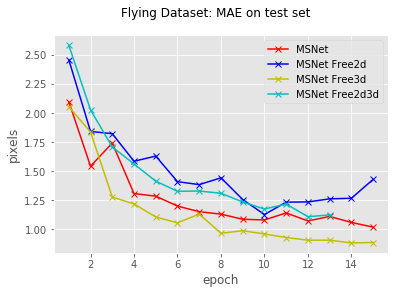

In [5]:
paths_to_results_freiburg['scalable_net'] = '/home/givasile/stereo_vision/saved_models/vol2/merging_info_net_custom_features/experiment_1/checkpoint_15.tar'

# figure 2
fig, ax = plt.subplots(1, 1)

for i, key in enumerate(paths_to_results_freiburg.keys()):
    # load mean of each array 
    stats = torch.load(paths_to_results_freiburg[key])['stats']
    if key in ['scalable_net', 'scalable_net_free_2d', 'scalable_net_free_3d']:
        arr = np.array(stats["test_full"]["mae"]['0_after'])
    elif key == 'scalable_net_free_2d_3d':
        lis = stats["test_full"]["mae"]['0_after']
        
    # plot line 
    if key == 'scalable_net':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax.plot(x , y, 'r-x', label = key1[key])
    elif key == 'scalable_net_free_2d':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax.plot(x, y, 'b-x', label = key1[key])
    elif key == 'scalable_net_free_3d':
        y = arr.mean(1)
        x = np.arange(1, y.shape[0] + 1)
        ax.plot(x, y, 'y-x', label = key1[key])
    elif key == 'scalable_net_free_2d_3d':
        tmp = []
        for i in range(len(lis)):
            tmp.append(np.mean(lis[i]))
        ax.plot(np.arange(1, len(tmp) + 1), tmp, 'c-x', label = key1[key])
        
fig.suptitle("Flying Dataset: MAE on test set")
ax.set_ylabel("pixels")
ax.set_xlabel("epoch")
ax.legend()

fig.savefig(dir_to_save + 'mae_test_set_scalable_vs_scalable_free_freiburg.png')

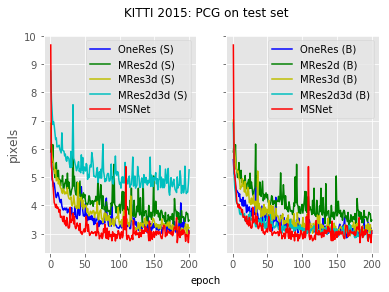

In [6]:
# figure 1
fig, ax = plt.subplots(1, 2, sharey='row')

def compute_mean_per_epoch(lis):
    mae = []
    for epoch in lis:
        mae.append(np.mean(epoch))
    return np.array(mae)

for i, key in enumerate(paths_to_results_kitti2015.keys()):
    if paths_to_results_kitti2015[key] is not None:
        # load mean of each array 
        stats = torch.load(paths_to_results_kitti2015[key])['stats']
        if key in ['one_res_small', 'one_res_big', 'mres_2d_small']:
            arr = np.array(stats["val_full"]["pcg"])
        elif key in ['mres_2d_big']:
            arr = arr
        elif key in ['mres_3d_small', 'mres_3d_big', 'mres_2d_3d_small', 'mres_2d_3d_big']:
            arr = np.array(stats["val_full"]["pcg"]['_4'])
        elif key in ['scalable_net']:
            arr = np.array(stats["val_full"]["pcg"]['0_after'])

        # plot line
        if key == 'one_res_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'b-', label = key1[key])
        elif key == 'one_res_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'b-', label = key1[key])
        elif key == 'mres_2d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x ,y, 'g-', label = key1[key])
        elif key == 'mres_2d_big':
            y = compute_mean_per_epoch(arr)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'g-', label = key1[key])
        elif key == 'mres_3d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'y-', label = key1[key])
        elif key == 'mres_3d_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'y-', label = key1[key])
        elif key == 'mres_2d_3d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'c-', label = key1[key])
        elif key == 'mres_2d_3d_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'c-', label = key1[key])    
        elif key == 'scalable_net':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'r-', label = key1[key])
            ax[1].plot(x, y, 'r-', label = key1[key])
        
fig.suptitle("KITTI 2015: PCG on test set")
ax[0].set_ylabel("pixels")
fig.text(0.5, 0.02, 'epoch', ha='center')
ax[0].legend()
ax[1].legend()

fig.savefig(dir_to_save + 'pcg_test_set_scalable_vs_simple_nets_kitti2015.png')

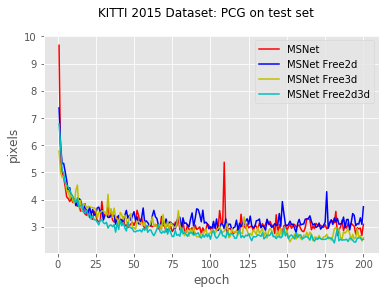

In [7]:
# figure 2
fig, ax = plt.subplots(1, 1)

for i, key in enumerate(paths_to_results_kitti2015.keys()):
    if paths_to_results_kitti2015[key] is not None:
        # load mean of each array 
        stats = torch.load(paths_to_results_kitti2015[key])['stats']
        if key in ['scalable_net', 'scalable_net_free_2d', 'scalable_net_free_3d']:
            arr = np.array(stats["val_full"]["pcg"]['0_after'])
        elif key == 'scalable_net_free_2d_3d':
            lis = stats["val_full"]["pcg"]['0_after']

        # plot line 
        if key == 'scalable_net':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x , y, 'r-', label = key1[key])
        elif key == 'scalable_net_free_2d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'b-', label = key1[key])
        elif key == 'scalable_net_free_3d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'y-', label = key1[key])
        elif key == 'scalable_net_free_2d_3d':
            tmp = []
            for i in range(len(lis)):
                tmp.append(np.mean(lis[i]))
            ax.plot(np.arange(1, len(tmp) + 1), tmp, 'c-', label = key1[key])
        
fig.suptitle("KITTI 2015 Dataset: PCG on test set")
ax.set_ylabel("pixels")
ax.set_xlabel("epoch")
ax.legend()

fig.savefig(dir_to_save + 'pcg_test_set_scalable_vs_scalable_free_kitti2015.png')

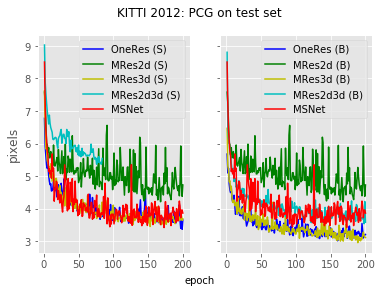

In [10]:
# figure 1
fig, ax = plt.subplots(1, 2, sharey='row')

def compute_mean_per_epoch(lis):
    mae = []
    for epoch in lis:
        mae.append(np.mean(epoch))
    return np.array(mae)

for i, key in enumerate(paths_to_results_kitti2012.keys()):
    if paths_to_results_kitti2012[key] is not None:
        # load mean of each array 
        stats = torch.load(paths_to_results_kitti2012[key])['stats']
        if key in ['one_res_small', 'one_res_big', 'mres_2d_small']:
            arr = np.array(stats["val_full"]["pcg"])
        elif key in ['mres_2d_big']:
            arr = arr
        elif key in ['mres_3d_small', 'mres_3d_big', 'mres_2d_3d_small', 'mres_2d_3d_big']:
            arr = np.array(stats["val_full"]["pcg"]['_4'])
        elif key in ['scalable_net']:
            arr = np.array(stats["val_full"]["pcg"]['0_after'])

        # plot line
        if key == 'one_res_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'b-', label = key1[key])
        elif key == 'one_res_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'b-', label = key1[key])
        elif key == 'mres_2d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x ,y, 'g-', label = key1[key])
        elif key == 'mres_2d_big':
            y = compute_mean_per_epoch(arr)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'g-', label = key1[key])
        elif key == 'mres_3d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'y-', label = key1[key])
        elif key == 'mres_3d_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'y-', label = key1[key])
        elif key == 'mres_2d_3d_small':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'c-', label = key1[key])
        elif key == 'mres_2d_3d_big':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[1].plot(x, y, 'c-', label = key1[key])    
        elif key == 'scalable_net':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax[0].plot(x, y, 'r-', label = key1[key])
            ax[1].plot(x, y, 'r-', label = key1[key])
        
fig.suptitle("KITTI 2012: PCG on test set")
ax[0].set_ylabel("pixels")
fig.text(0.5, 0.02, 'epoch', ha='center')
ax[0].legend()
ax[1].legend()

fig.savefig(dir_to_save + 'pcg_test_set_scalable_vs_simple_nets_kitti2012.png')

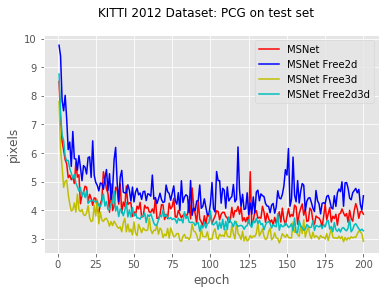

In [11]:
# figure 2
fig, ax = plt.subplots(1, 1)

for i, key in enumerate(paths_to_results_kitti2012.keys()):
    if paths_to_results_kitti2012[key] is not None:
        # load mean of each array 
        stats = torch.load(paths_to_results_kitti2012[key])['stats']
        if key in ['scalable_net', 'scalable_net_free_2d', 'scalable_net_free_3d']:
            arr = np.array(stats["val_full"]["pcg"]['0_after'])
        elif key == 'scalable_net_free_2d_3d':
            lis = stats["val_full"]["pcg"]['0_after']

        # plot line 
        if key == 'scalable_net':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x , y, 'r-', label = key1[key])
        elif key == 'scalable_net_free_2d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'b-', label = key1[key])
        elif key == 'scalable_net_free_3d':
            y = arr.mean(1)
            x = np.arange(1, y.shape[0] + 1)
            ax.plot(x, y, 'y-', label = key1[key])
        elif key == 'scalable_net_free_2d_3d':
            tmp = []
            for i in range(len(lis)):
                tmp.append(np.mean(lis[i]))
            ax.plot(np.arange(1, len(tmp) + 1), tmp, 'c-', label = key1[key])
        
fig.suptitle("KITTI 2012 Dataset: PCG on test set")
ax.set_ylabel("pixels")
ax.set_xlabel("epoch")
ax.legend()

fig.savefig(dir_to_save + 'pcg_test_set_scalable_vs_scalable_free_kitti2012.png')